In [2]:
import re
import pandas as pd
from datetime import datetime

# --- Load your log files ---
with open("mail.log", "r", encoding="utf-8", errors="replace") as f:
    postfix_lines = f.readlines()

with open("cse_roundcube_userlogins.log", "r", encoding="utf-8", errors="replace") as f:
    roundcube_lines = f.readlines()

# --- Prepare regex patterns ---
# Extended to match all service logs with PID
service_pattern = re.compile(
    r"(?P<month>\w{3})\s+(?P<day>\d{1,2})\s+(?P<time>\d{2}:\d{2}:\d{2})\s+\S+\s+(?P<service>\S+?)\[(?P<pid>\d+)\]:\s+(?P<message>.+)"
)

# Roundcube Patterns
pattern_full = re.compile(
    r"\[(?P<timestamp>\d{2}-\w{3}-\d{4} \d{2}:\d{2}:\d{2} [+-]\d{4})\]:\s"
    r"<(?P<session_id>[^>]+)>\s(?P<status>Successful|Failed) login for\s*(?P<username>.+?)"
    r"(?: \(ID: (?P<user_id>\d+)\))?\sfrom (?P<internal_ip>[\d.]+)"
    r"\(?(?:X-Real-IP: (?P<real_ip>[\d.]+),)?X-Forwarded-For: (?P<forwarded_ip>[^)]+)\)?"
    r"\s*in session (?P<session_id2>[^\s]+)?(?: \(error: (?P<error_code>\d+)\))?"
)


pattern_mid = re.compile(
    r"\[(?P<timestamp>\d{2}-\w{3}-\d{4} \d{2}:\d{2}:\d{2} [+-]\d{4})\]:\s"
    r"<(?P<session_id>[^>]+)>\s(?P<status>Successful|Failed) login for\s*(?P<username>.+?)"
    r"(?: \(ID: (?P<user_id>\d+)\))?\sfrom (?P<internal_ip>[\d.]+)\s"
    r"in session\s(?P<session_id2>\w+)(?: \(error: (?P<error_code>\d+)\))?"
)


pattern_minimal = re.compile(
    r"\[(?P<timestamp>\d{2}-\w{3}-\d{4} \d{2}:\d{2}:\d{2} [+-]\d{4})\]:\s"
    r"\[roundcube\]\sFAILED login for\s*(?P<username>.+?)\sfrom\s(?P<internal_ip>[\d.]+)"
)



# --- Extract features ---
postfix_logs = []
roundcube_logs = []
unmatched_postfix_lines = []
unmatched_roundcube_lines = []

# --- Process Postfix logs ---
for line in postfix_lines:
    match = service_pattern.search(line)
    if match:
        msg = match.group("message")
        postfix_logs.append({
            "timestamp": f"{match.group('month')} {match.group('day')} {match.group('time')}",
            "service": match.group("service"),
            "pid": int(match.group("pid")),
            "event": msg.split(":")[0],
            "message": msg
        })
    else:
        unmatched_postfix_lines.append(line.strip())

# --- Process Roundcube logs ---
for line in roundcube_lines:
    m1 = pattern_full.search(line)
    m3 = pattern_minimal.search(line)
    m2 = pattern_mid.search(line)
    

    if m1:
        roundcube_logs.append({
        "timestamp": m1.group("timestamp"),
        "session_id": m1.group("session_id2") or m1.group("session_id"),
        "username": m1.group("username").strip() if m1.group("username") else None,
        "user_id": int(m1.group("user_id")) if m1.group("user_id") else None,
        "internal_ip": m1.group("internal_ip"),
        "real_ip": m1.group("real_ip") if m1.group("real_ip") else None,
        "forwarded_ip": m1.group("forwarded_ip").strip(),
        "status": m1.group("status"),
        "error_code": int(m1.group("error_code")) if m1.group("error_code") else 0
    })
    elif m2:
        roundcube_logs.append({
            "timestamp": m2.group("timestamp"),
            "session_id": m2.group("session_id"),
            "username": m2.group("username"),
            "user_id": int(m2.group("user_id")) if m2.group("user_id") else None,
            "internal_ip": m2.group("internal_ip"),
            "real_ip": None,
            "forwarded_ip": None,
            "status": m2.group("status"),
            "error_code": int(m2.group("error_code")) if m2.group("error_code") else 0
        })
    elif m3:
        roundcube_logs.append({
        "timestamp": m3.group("timestamp"),
        "session_id": None,
        "username": m3.group("username").strip(),
        "user_id": None,
        "internal_ip": m3.group("internal_ip"),
        "real_ip": None,
        "forwarded_ip": None,
        "status": "Failed",
        "error_code": 0
    })
    else:
        unmatched_roundcube_lines.append(line.strip())

# --- Convert to DataFrames ---
df_postfix = pd.DataFrame(postfix_logs)
df_roundcube = pd.DataFrame(roundcube_logs)

# --- Convert timestamps ---
if not df_postfix.empty:
    df_postfix["timestamp"] = pd.to_datetime(
        df_postfix["timestamp"] + f" {datetime.now().year}",
        format="%b %d %H:%M:%S %Y", errors="coerce"
    )

if not df_roundcube.empty:
    df_roundcube["timestamp"] = pd.to_datetime(
        df_roundcube["timestamp"], format="%d-%b-%Y %H:%M:%S %z", errors="coerce"
    )

# --- Save extracted features ---
df_postfix.to_csv("postfix_features.csv", index=False)
df_roundcube.to_csv("roundcube_features.csv", index=False)

# --- Save unmatched logs ---
with open("unmatched_postfix_logs.txt", "w", encoding="utf-8", errors="replace") as f:
    # Write unmatched Postfix lines
    f.writelines(line + "\n" for line in unmatched_postfix_lines)

with open("unmatched_roundcube_logs.txt", "w", encoding="utf-8", errors="replace") as f:
    # Write unmatched Roundcube lines
    f.writelines(line + "\n" for line in unmatched_roundcube_lines)

# --- Summary ---
def safe_print(s):
    print(s.encode("utf-8", errors="replace").decode("utf-8"))

safe_print(f"✅ Features extracted and saved for both Postfix and Roundcube logs.")
safe_print(f"Postfix logs: Extracted {len(df_postfix)}, Unmatched {len(unmatched_postfix_lines)}")
safe_print(f"Roundcube logs: Extracted {len(df_roundcube)}, Unmatched {len(unmatched_roundcube_lines)}")
safe_print("📁 Unmatched logs saved to 'unmatched_postfix_logs.txt' and 'unmatched_roundcube_logs.txt'")



✅ Features extracted and saved for both Postfix and Roundcube logs.
Postfix logs: Extracted 1571441, Unmatched 0
Roundcube logs: Extracted 102092, Unmatched 0
📁 Unmatched logs saved to 'unmatched_postfix_logs.txt' and 'unmatched_roundcube_logs.txt'


In [3]:
df = pd.read_csv("postfix_features.csv", parse_dates=["timestamp"])

In [4]:
from sklearn.preprocessing import LabelEncoder

# Create encoders
le_service = LabelEncoder()
le_event = LabelEncoder()

# Apply encoding
df["service_encoded"] = le_service.fit_transform(df["service"])
df["event_encoded"] = le_event.fit_transform(df["event"])

In [5]:
df.head()

,timestamp,service,pid,event,message,service_encoded,event_encoded
0,2025-05-19 06:26:54,postfix/scache,5973,statistics,statistics: start interval May 19 06:25:09,12,15510
1,2025-05-19 06:26:54,postfix/scache,5973,statistics,statistics: domain lookup hits=0 miss=1 succes...,12,15510
2,2025-05-19 06:26:54,postfix/scache,5973,statistics,statistics: max simultaneous domains=1 address...,12,15510
3,2025-05-19 06:27:23,postfix/smtpd,5929,idle timeout -- exiting,idle timeout -- exiting,14,8191
4,2025-05-19 06:27:23,postfix/smtpd,5492,watchdog_start,watchdog_start: 0x55c34ff7fd40,14,15539


In [6]:
df["hour"] = df["timestamp"].dt.hour
df["minute"] = df["timestamp"].dt.minute
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["msg_len"] = df["message"].str.len()


In [7]:
df.head()


,timestamp,service,pid,event,message,service_encoded,event_encoded,hour,minute,dayofweek,msg_len
0,2025-05-19 06:26:54,postfix/scache,5973,statistics,statistics: start interval May 19 06:25:09,12,15510,6,26,0,42
1,2025-05-19 06:26:54,postfix/scache,5973,statistics,statistics: domain lookup hits=0 miss=1 succes...,12,15510,6,26,0,50
2,2025-05-19 06:26:54,postfix/scache,5973,statistics,statistics: max simultaneous domains=1 address...,12,15510,6,26,0,63
3,2025-05-19 06:27:23,postfix/smtpd,5929,idle timeout -- exiting,idle timeout -- exiting,14,8191,6,27,0,23
4,2025-05-19 06:27:23,postfix/smtpd,5492,watchdog_start,watchdog_start: 0x55c34ff7fd40,14,15539,6,27,0,30


In [8]:
features = df[["service_encoded", "event_encoded", "hour", "minute", "dayofweek", "msg_len"]]


In [9]:
features.head()

,service_encoded,event_encoded,hour,minute,dayofweek,msg_len
0,12,15510,6,26,0,42
1,12,15510,6,26,0,50
2,12,15510,6,26,0,63
3,14,8191,6,27,0,23
4,14,15539,6,27,0,30


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
model.fit(features_scaled)  # <-- Fit the model first!
df["anomaly_score"] = model.decision_function(features_scaled)
df["is_anomaly"] = model.predict(features_scaled)  # -1 = anomaly, 1 = normal

anomalies = df[df["is_anomaly"] == -1].sort_values("anomaly_score")




In [11]:
print("\n🔎 Top 10 Most Anomalous Logs:\n")
print(anomalies[[
    "timestamp", "service", "event", "hour", "minute", "dayofweek", "msg_len", "anomaly_score"
]].head(10))
anomalies.to_csv("postfix_anomalies.csv", index=False)



🔎 Top 10 Most Anomalous Logs:

                  timestamp          service        event  hour  minute  \
1532026 2025-05-19 16:44:29    postfix/error  1704FF40C0A    16      44   
1313987 2025-05-19 15:34:29    postfix/error  1704FF40C0A    15      34   
1485042 2025-05-19 16:30:29  postfix/cleanup  391DDF40C00    16      30   
1532024 2025-05-19 16:44:29    postfix/error  4377DF40C03    16      44   
888775  2025-05-19 12:20:20    postfix/error  4377DF40C03    12      20   
421863  2025-05-19 10:00:20    postfix/error  4377DF40C03    10       0   
1313986 2025-05-19 15:34:29    postfix/error  4377DF40C03    15      34   
708498  2025-05-19 11:10:20    postfix/error  4377DF40C03    11      10   
1121333 2025-05-19 14:24:39    postfix/error  4377DF40C03    14      24   
2622    2025-05-19 06:30:19    postfix/error  4377DF40C03     6      30   

         dayofweek  msg_len  anomaly_score  
1532026          0      213      -0.047523  
1313987          0      213      -0.045326  
1485042

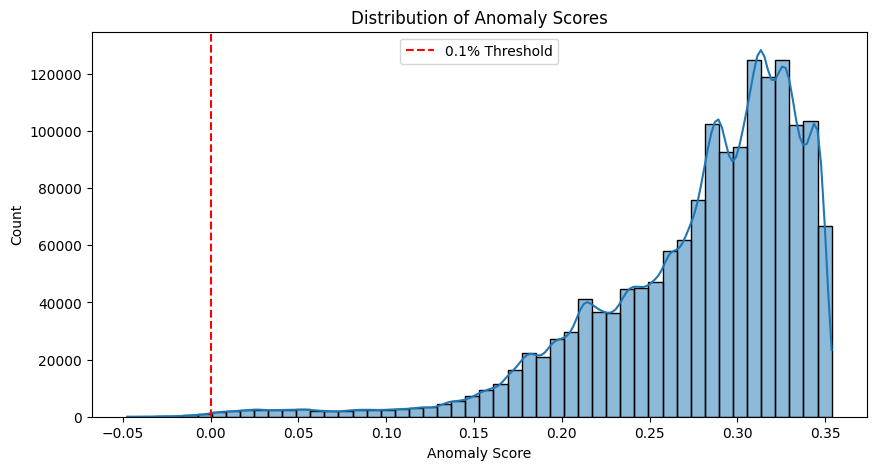

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.histplot(df["anomaly_score"], bins=50, kde=True)
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.axvline(x=df["anomaly_score"].quantile(0.001), color="red", linestyle="--", label="0.1% Threshold")
plt.legend()
plt.show()

In [ ]:
import joblib
# Save the model and scaler
joblib.dump(model, "anomaly_det.pkl")
joblib.dump(scaler, "scaler.pkl")



['New_scaler.pkl']